In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

In [ ]:
train.shape, test.shape

In [ ]:
train.head(3)
test.head(3)

# 2. EDA & 전처리

In [ ]:
train.info()
train.describe()
train.describe(include='O')

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## outlier

### education

In [5]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [6]:
df = pd.concat([train, test])
df.shape

(32561, 14)

In [7]:
df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)

In [8]:
capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()

In [9]:
train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')

In [10]:
train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']

In [11]:
train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

#### workclass Without-pay, Never-worked 묶기

In [12]:
train['workclass'].replace(['Without-pay','Never-worked'],['No-money','No-money'],inplace=True)
test['workclass'].replace(['Without-pay','Never-worked'],['No-money','No-money'],inplace=True)

In [13]:
train.workclass.value_counts()

Private             18123
Self-emp-not-inc     2030
Local-gov            1692
?                    1502
State-gov            1043
Self-emp-inc          877
Federal-gov           765
No-money               17
Name: workclass, dtype: int64

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns

In [14]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=col_cat
          , numeric_features = ['education_num']
          #, ignore_features =tp.tolist() + wr.tolist() + wf.tolist()#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 14)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 29 s


In [15]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.8649,0.9217,0.6484,0.7592,0.6992,0.6128,0.6162,2.1057
1,Light Gradient Boosting Machine,0.8646,0.9206,0.6432,0.7609,0.6969,0.6105,0.6143,0.2922
2,CatBoost Classifier,0.8660,0.9238,0.6355,0.7713,0.6964,0.6115,0.6165,10.7034
3,Gradient Boosting Classifier,0.8636,0.9177,0.6099,0.7788,0.6839,0.5985,0.6060,1.9546
4,Ada Boost Classifier,0.8574,0.9115,0.6180,0.7492,0.6771,0.5867,0.5913,0.7063
5,Linear Discriminant Analysis,0.8460,0.9000,0.5927,0.7216,0.6504,0.5529,0.5576,0.1643
6,Extra Trees Classifier,0.8364,0.8836,0.5995,0.6861,0.6395,0.5344,0.5367,0.5366
7,Random Forest Classifier,0.8431,0.8765,0.5630,0.7273,0.6345,0.5367,0.5439,0.1262


In [16]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8680,0.9226,0.6456,0.7718,0.7031,0.6191,0.6232
1,0.8598,0.9173,0.6424,0.7434,0.6892,0.5993,0.6020
2,0.8570,0.9216,0.6214,0.7456,0.6778,0.5869,0.5910
3,0.8754,0.9299,0.6418,0.8032,0.7135,0.6352,0.6417
4,0.8711,0.9246,0.6634,0.7721,0.7137,0.6311,0.6341
Mean,0.8663,0.9232,0.6429,0.7672,0.6995,0.6143,0.6184
SD,0.0069,0.0041,0.0134,0.0218,0.0140,0.0185,0.0191


In [17]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8731,0.9284,0.6616,0.7807,0.7163,0.6353,0.6389


In [22]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 1s


In [23]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [24]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [25]:
submission.to_csv('output/20201016-3.csv')

In [18]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8614,0.9121,0.5955,0.7797,0.6752,0.5891,0.5978
1,0.8630,0.9142,0.6246,0.7659,0.6881,0.6014,0.6065
2,0.8590,0.9095,0.6278,0.7490,0.6831,0.5934,0.5972
3,0.8574,0.9074,0.5909,0.7647,0.6667,0.5778,0.5856
4,0.8582,0.9109,0.5922,0.7689,0.6691,0.5808,0.5888
5,0.8636,0.9278,0.6052,0.7824,0.6825,0.5975,0.6054
6,0.8723,0.9367,0.6149,0.8120,0.6998,0.6206,0.6303
7,0.8605,0.9188,0.5922,0.7787,0.6728,0.5862,0.5951
8,0.8636,0.9222,0.5987,0.7872,0.6801,0.5955,0.6045
9,0.8770,0.9179,0.6570,0.7992,0.7211,0.6432,0.6483


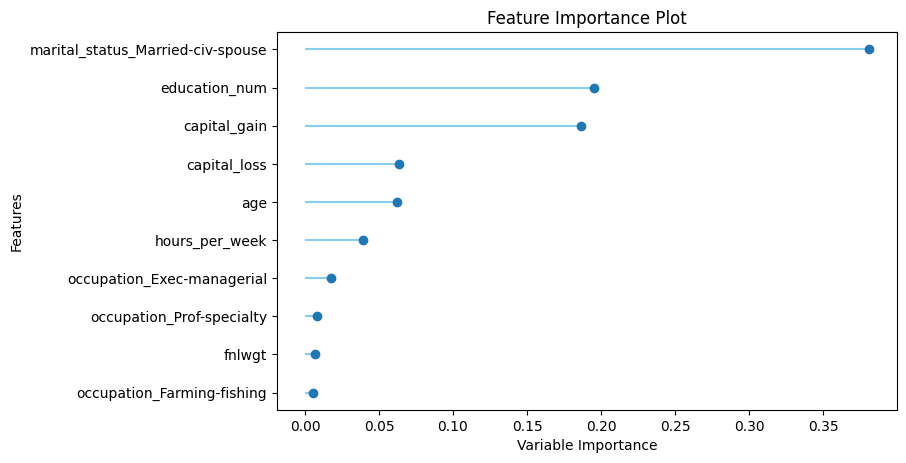

In [19]:
plot_model(estimator = gbc, plot = 'feature')

In [20]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8630,0.9202,0.6246,0.7659,0.6881,0.6014,0.6065
1,0.8614,0.9191,0.6602,0.7391,0.6974,0.6079,0.6095
2,0.8614,0.9161,0.6602,0.7391,0.6974,0.6079,0.6095
3,0.8574,0.9120,0.6169,0.7480,0.6762,0.5858,0.5903
4,0.8503,0.9091,0.6052,0.7305,0.6619,0.5669,0.5710
5,0.8699,0.9311,0.6667,0.7658,0.7128,0.6292,0.6318
6,0.8824,0.9357,0.6634,0.8167,0.7321,0.6579,0.6637
7,0.8605,0.9196,0.6278,0.7549,0.6855,0.5969,0.6010
8,0.8715,0.9240,0.6440,0.7866,0.7082,0.6268,0.6320
9,0.8683,0.9187,0.6634,0.7621,0.7093,0.6248,0.6273


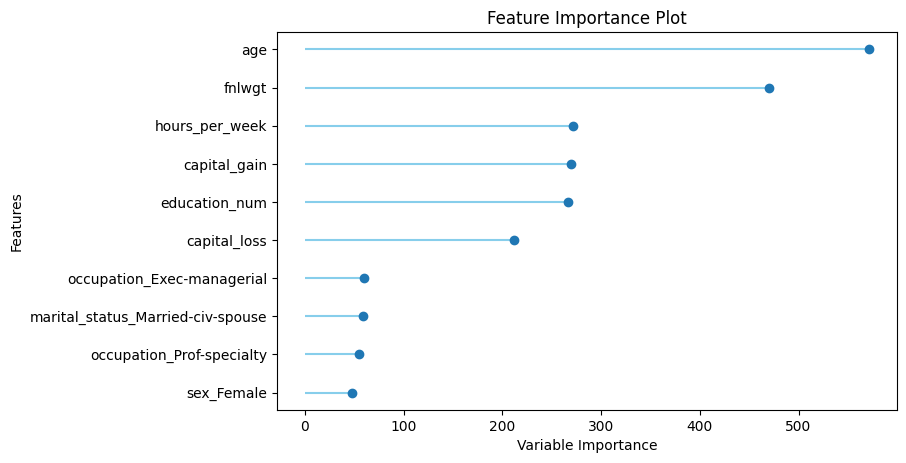

In [21]:
plot_model(estimator = lightgbm, plot = 'feature')